В данном ноутбуке представлены эксперименты с использованием сверточных нейронных сетей.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re
import sys
import os

import numpy as np
from tqdm import tqdm
import pandas as pd
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim.models import word2vec
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import seaborn as sns
import warnings

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics
from word2vec_utils import Word2VecVectorizer, Word2VecTfIdfVectorizer

RANDOM_STATE = 41825352

sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision('medium')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузим данные которые были предобработаны в ноутбуке `min_baseline.ipynb`.

In [2]:
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Предобработаем тексты пресс-релизов.

In [3]:
# инициализируем лемматизатор
mystem = Mystem()

# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))


# функция для препроцессинга текста
def preprocessor(text):

    # приводим к нижнему регистру
    text = text.lower()

    # удаляем все символы, кроме пробелов и русских букв.
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)

    # лемматизируем тексты
    text = " ".join(mystem.lemmatize(text))

    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text


Xpreproc = X.release.apply(preprocessor)

### Word2Vec

Обучим Word2Vec на нашем датасете и подготовим эмбеддинги. Сеть будет принимать на вход тензор размерность `batch_size x max_sent_len x embedding_size`, где `max_send_len` - число токенов в самом длинном тексте. Остальные тексты должны быть дополнены до данного размера при помощи отдельного токена.

In [4]:
PADDING_TOKEN = '<pad>' # токен для паддинга
EMBEDDING_SIZE = 50

# добавляем токен в каждый текст, чтобы w2v при обучении запомнил его
data = Xpreproc.str.split().apply(lambda x: x + [PADDING_TOKEN])
w2v = word2vec.Word2Vec(data, window=5, workers=1, sg=0, vector_size=EMBEDDING_SIZE, seed=RANDOM_STATE)

In [5]:
class EmbeddingVectors:
    """
    Контейнер для эмбеддингов всех слов из словаря
    """
    def __init__(self, vectors, padding_idx=None):
        self.vectors = vectors
        self.padding_idx = padding_idx
        self._size = vectors.shape[1]

    @property
    def size(self):
        return self._size

    @staticmethod
    def from_w2v(w2v: word2vec.Word2Vec, padding_token):
        return EmbeddingVectors(w2v.vectors, w2v.get_index(padding_token) if padding_token else None)

Ниже представлена сверточная модель, реализованная по [Zhang, 2015](https://arxiv.org/abs/1510.03820).

In [6]:
class CnnTextClassifier(nn.Module):
    def __init__(self, embeddings, num_classes, window_sizes=(3, 4, 5), num_filters=256):
        super(CnnTextClassifier, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embeddings.vectors),
            padding_idx=embeddings.padding_idx,
        )
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (window_size, embeddings.size), padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(num_filters * len(window_sizes), num_classes),
        )

    def forward(self, x):
        x = self.embedding(x)

        if len(x.size()) < 4:
            x = torch.unsqueeze(x, 1)
        
        xs = []
        for conv in self.convs:
            x2 = torch.relu(conv(x)).squeeze(-1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        
        x = torch.cat(xs, dim=2)

        logits = self.head(x)
        probs = F.softmax(logits, dim=1)

        return probs

Далее преобразуем слова каждого текста в индексы из словаря Word2Vec, кодируем целевую переменную (для работы с `CrossEntropyLoss`).

In [7]:
def make_word2vec_vector_cnn(sentence, wv, padding_idx, max_len):
    padded_X = [padding_idx for i in range(max_len)]
    i = 0
    for word in sentence:
        if word not in wv:
            padded_X[i] = 0
        else:
            padded_X[i] = wv.get_index(word)
        i += 1
    return torch.tensor(padded_X, dtype=torch.long).view(1, -1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
padding_idx = w2v.wv.get_index(PADDING_TOKEN)
max_len = data.apply(len).max()

target_enc = LabelEncoder()
y_enc = target_enc.fit_transform(y)

data1 = torch.stack(data.apply(lambda x: make_word2vec_vector_cnn(x, w2v.wv, padding_idx, max_len)).tolist()).squeeze(1).to(device)
y1 = torch.tensor(y_enc, dtype=torch.long).to(device)

Наконец, обучим модель:

In [14]:
def train(X, y, num_epochs, factory, start_from=30):
    y_preds = []
    y_preds_proba = []

    prog = tqdm(range(start_from, len(y)))
    for threshold in prog:
        ds = TensorDataset(X[:threshold], y[:threshold])
        dl = DataLoader(ds, 32, shuffle=False)
        
        cnn_model, optimizer, scheduler = factory()
        cnn_model.to(device)
        loss_function = nn.CrossEntropyLoss()

        cnn_model.train()
        for epoch in range(num_epochs):
            for bx, by in dl:
                cnn_model.zero_grad()
                probs = cnn_model(bx)
                loss = loss_function(probs, by)
                loss.backward()
                optimizer.step()

            if scheduler:
                scheduler.step()
            if epoch % 20 == 0:
                prog.set_postfix_str(f'loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}')

        cnn_model.eval()
        probs = cnn_model(X[threshold:threshold+1])
        pred = torch.argmax(probs)
        y_preds_proba.append(probs.detach().cpu().numpy().reshape(-1))
        y_preds.append(pred.detach().cpu().numpy().item())

    return np.array(y_preds), np.array(y_preds_proba)

In [15]:
def create_model():
    embeddings = EmbeddingVectors.from_w2v(w2v.wv, PADDING_TOKEN)
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler


num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 69/69 [24:53<00:00, 21.64s/it, loss = 0.5514559745788574, lr = 1e-05] 


Посмотрим на получившиеся метрики:

In [16]:
def print_metrics(name, y, y_preds, y_preds_proba, start_from=30):
    y = y[start_from:]
    acc = accuracy_score(y, y_preds)
    f1 = f1_score(y, y_preds, average="macro")
    recall = recall_score(y, y_preds, average="macro")
    precision = precision_score(y, y_preds, average="macro")
    roc_auc_ovr = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovr")
    roc_auc_ovo = roc_auc_score(y, y_preds_proba, average="macro", multi_class="ovo")

    print(classification_report(y, y_preds))
    cm = confusion_matrix(y, y_preds)
    cm = pd.DataFrame(cm, index=["-1", "0", "1"], columns=["-1", "0", "1"])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return pd.DataFrame({
        'accuracy': acc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'roc_auc_ovr': roc_auc_ovr,
        'roc_auc_ovo': roc_auc_ovo,
        }, index=[name])

              precision    recall  f1-score   support

        -1.0       0.57      0.52      0.55        23
         0.0       0.44      0.56      0.49        27
         1.0       0.64      0.47      0.55        19

    accuracy                           0.52        69
   macro avg       0.55      0.52      0.53        69
weighted avg       0.54      0.52      0.52        69



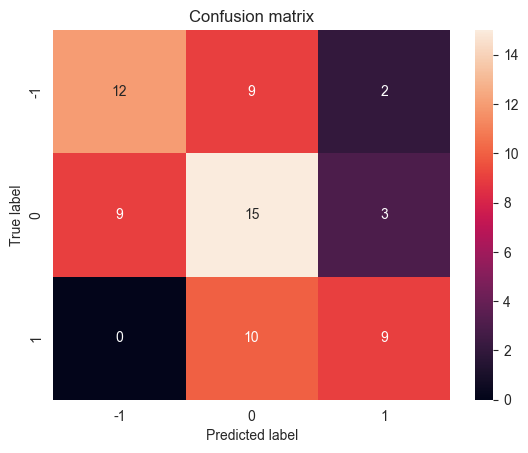

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
CNN Word2Vec,0.521739,0.527571,0.516993,0.551821,0.699277,0.706204


In [17]:
print_metrics('CNN Word2Vec', y, target_enc.inverse_transform(y_preds), y_preds_proba)

Качество модели не слишком высокое в сравнении даже с линейными моделями.

### Word2Vec Pretrained

TODO ...

In [12]:
import gensim.downloader as api
from pymorphy3 import MorphAnalyzer

w2v_ruscorpora = api.load('word2vec-ruscorpora-300')

# функция для добавления части речи к словам
def tag(words):
    morph = MorphAnalyzer()
    parts = [str(morph.parse(word)[0].tag.POS) for word in words]
    return [word + '_' + part for word, part in zip(words, parts)]

data = Xpreproc.str.split().apply(tag)

In [13]:
padding_idx = 9999
max_len = data.apply(len).max()

data1 = torch.stack(data.apply(lambda x: make_word2vec_vector_cnn(x, w2v_ruscorpora, padding_idx, max_len)).tolist()).squeeze(1).to(device)

In [ ]:
def create_model():
    embeddings = EmbeddingVectors.from_w2v(w2v_ruscorpora, w2v_ruscorpora.index_to_key[padding_idx])
    cnn_model = CnnTextClassifier(embeddings, num_classes=3)
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    return cnn_model, optimizer, scheduler


num_epochs = 1000
y_preds, y_preds_proba = train(data1, y1, num_epochs, create_model)

100%|██████████| 69/69 [52:38<00:00, 45.78s/it, loss = 0.5514844655990601, lr = 1e-05] 


              precision    recall  f1-score   support

        -1.0       0.71      0.74      0.72        23
         0.0       0.55      0.63      0.59        27
         1.0       0.79      0.58      0.67        19

    accuracy                           0.65        69
   macro avg       0.68      0.65      0.66        69
weighted avg       0.67      0.65      0.65        69



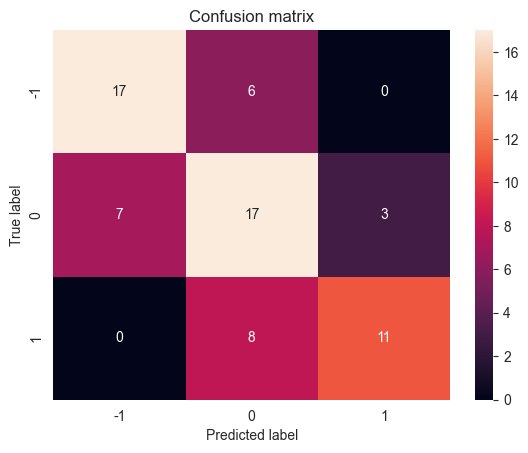

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
CNN Word2Vec pretrained,0.652174,0.658759,0.649236,0.680812,0.752054,0.757494


In [15]:
print_metrics('CNN Word2Vec pretrained', y, target_enc.inverse_transform(y_preds), y_preds_proba)

### Glove

TODO ...

### 1D TF-IDF

Кодирование TF-IDF также можно рассматривать в качестве векторного представления слов - только вектор получается одномерным.

TODO ...

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=8)
tf_idf = vectorizer.fit_transform(Xpreproc).todense()

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_SIZE = len(vectorizer.vocabulary_)

# https://chriskhanhtran.github.io/posts/cnn-sentence-classification/#31-create-cnn-model

class CnnTextClassifier(nn.Module):
    def __init__(self, num_classes, window_sizes=(2,3,5,7)):
        super(CnnTextClassifier, self).__init__()
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 64, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(64 * len(window_sizes), num_classes)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        if len(x.size()) < 4:
            x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.relu(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        x = x.view(x.size(0), -1)
        logits = self.fc(self.dropout(x))

        probs = F.softmax(logits, dim=1)

        return probs

NameError: name 'vectorizer' is not defined

In [ ]:
def make_target(label):
    return torch.tensor([int(label)+1], dtype=torch.long, device=device)

y1 = torch.stack(y.apply(make_target).tolist()).squeeze().to(device)
data1 = torch.tensor(tf_idf, dtype=torch.float).unsqueeze(1).to(device)

In [18]:
num_epochs = 1000

y_preds = []
y_preds_proba = []

prog = tqdm(range(30, len(y)))
for threshold in prog:
    cnn_model = CnnTextClassifier(num_classes=3)
    cnn_model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(cnn_model.parameters(), lr=0.001, fused=True)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 800])
    
    cnn_model.train()
    for epoch in range(num_epochs):
        cnn_model.zero_grad()
        bow_vec = data1[:threshold]
        probs = cnn_model(bow_vec)
        target = y1[:threshold]
        loss = loss_function(probs, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 20 == 0:
            prog.set_postfix_str(f'loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}')

    cnn_model.eval()
    bow_vec = data1[threshold:threshold+1]
    probs = cnn_model(bow_vec)
    pred = torch.argmax(probs) - 1
    y_preds_proba.append(probs.detach().cpu().numpy())
    y_preds.append(pred.detach().cpu().numpy().item())

  0%|          | 0/69 [00:00<?, ?it/s]


TypeError: CnnTextClassifier.__init__() missing 1 required positional argument: 'embeddings'

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

accuracy_score(y_preds, y[30:])

0.6811594202898551

In [ ]:
roc_auc_score(
    y[30:],
    np.concatenate(y_preds_proba, axis=0),
    average="macro",
    multi_class="ovo",
)

0.759118004350651

In [ ]:
print(classification_report(y_preds, y[30:]))

              precision    recall  f1-score   support

          -1       0.78      0.69      0.73        26
           0       0.56      0.60      0.58        25
           1       0.74      0.78      0.76        18

    accuracy                           0.68        69
   macro avg       0.69      0.69      0.69        69
weighted avg       0.69      0.68      0.68        69



In [ ]:
confusion_matrix(y_preds, y[30:])

array([[18,  8,  0],
       [ 5, 15,  5],
       [ 0,  4, 14]], dtype=int64)